In [4]:
# Cell 1: Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import math
import os
import time

from safetensors.torch import save_file, load_file

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [ ]:
# Cell 2: Mount Drive and set paths

from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = Path('/content/drive/MyDrive/notebooks_tacit/maze_dataset')
CHECKPOINT_DIR = Path('/content/drive/MyDrive/notebooks_tacit/checkpoints')
CHECKPOINT_DIR.mkdir(exist_ok=True)

# Verify data exists
batch_files = sorted(DATA_DIR.glob('batch_*.npz'))
print(f"Found {len(batch_files)} batch files")
print(f"First: {batch_files[0].name}")
print(f"Last: {batch_files[-1].name}")

Mounted at /content/drive
Found 100 batch files
First: batch_0000.npz
Last: batch_0099.npz


In [ ]:
# Cell 3: Dataset class

class MazeDataset(Dataset):
    """
    Dataset that loads maze pairs from .npz batch files.

    Loads batches lazily to avoid memory issues with 1M samples.
    """

    def __init__(self, data_dir: str, num_batches: int = None):
        """
        Args:
            data_dir: path to directory containing batch_XXXX.npz files
            num_batches: how many batches to use (None = all)
        """
        self.data_dir = Path(data_dir)
        self.batch_files = sorted(self.data_dir.glob('batch_*.npz'))

        if num_batches is not None:
            self.batch_files = self.batch_files[:num_batches]

        # Load first batch to get batch size
        first_batch = np.load(self.batch_files[0])
        self.batch_size = len(first_batch['inputs'])
        first_batch.close()

        self.total_samples = len(self.batch_files) * self.batch_size

        # Cache for current loaded batch (avoid reloading constantly)
        self._cached_batch_idx = -1
        self._cached_inputs = None
        self._cached_outputs = None

        print(f"Dataset: {self.total_samples:,} samples from {len(self.batch_files)} batches")

    def __len__(self):
        return self.total_samples

    def _load_batch(self, batch_idx: int):
        """Load a batch into cache."""
        if batch_idx != self._cached_batch_idx:
            batch_data = np.load(self.batch_files[batch_idx])
            self._cached_inputs = batch_data['inputs']
            self._cached_outputs = batch_data['outputs']
            self._cached_batch_idx = batch_idx
            batch_data.close()

    def __getitem__(self, idx: int):
        """
        Returns a single (input, output) pair as tensors.

        Images are converted from uint8 [0, 255] to float32 [0, 1]
        and from (H, W, C) to (C, H, W) for PyTorch.
        """
        batch_idx = idx // self.batch_size
        sample_idx = idx % self.batch_size

        self._load_batch(batch_idx)

        # Get images as numpy arrays
        input_img = self._cached_inputs[sample_idx]
        output_img = self._cached_outputs[sample_idx]

        # Convert to tensor: uint8 [0,255] -> float32 [0,1]
        # Transpose: (H, W, C) -> (C, H, W)
        input_tensor = torch.from_numpy(input_img).permute(2, 0, 1).float() / 255.0
        output_tensor = torch.from_numpy(output_img).permute(2, 0, 1).float() / 255.0

        return input_tensor, output_tensor

Dataset: 100,000 samples from 10 batches
Input shape: torch.Size([3, 64, 64])
Output shape: torch.Size([3, 64, 64])
Value range: [0.00, 1.00]


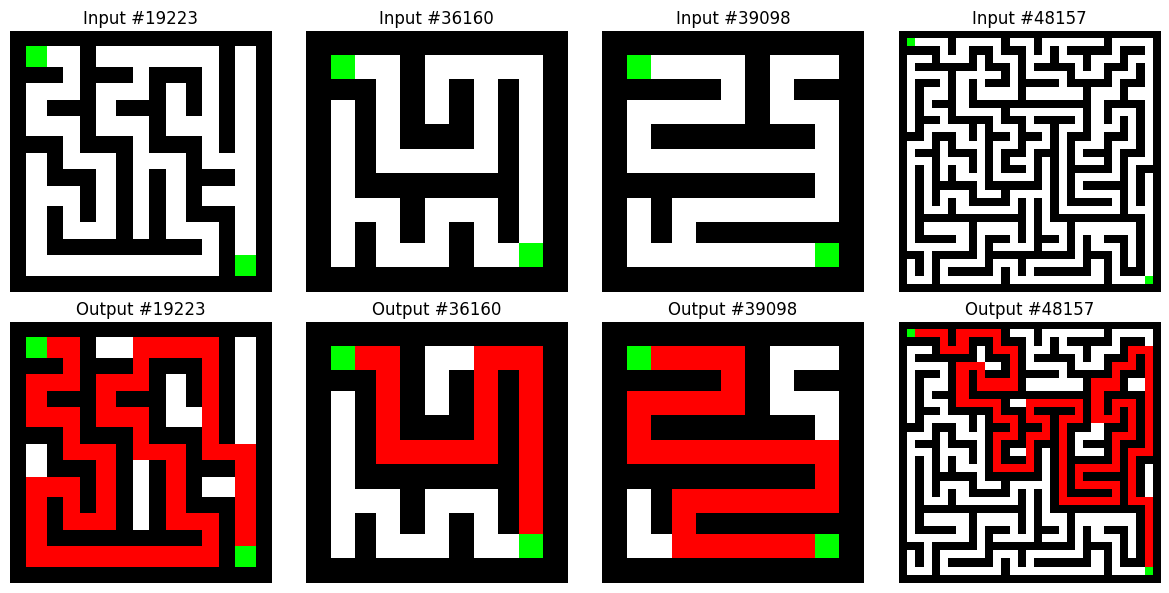

In [ ]:
# Cell 4: Test the dataset

dataset = MazeDataset(DATA_DIR, num_batches=10)  # Just 10 batches for testing

# Get a sample
inp, out = dataset[0]
print(f"Input shape: {inp.shape}")   # Should be (3, 64, 64)
print(f"Output shape: {out.shape}")  # Should be (3, 64, 64)
print(f"Value range: [{inp.min():.2f}, {inp.max():.2f}]")  # Should be [0, 1]

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    idx = np.random.randint(len(dataset))
    inp, out = dataset[idx]

    # Convert back to (H, W, C) for plotting
    axes[0, i].imshow(inp.permute(1, 2, 0))
    axes[0, i].set_title(f'Input #{idx}')
    axes[0, i].axis('off')

    axes[1, i].imshow(out.permute(1, 2, 0))
    axes[1, i].set_title(f'Output #{idx}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [2]:
# Cell 5: DataLoader

def create_dataloader(data_dir: str,
                      batch_size: int = 64,
                      num_batches: int = None,
                      shuffle: bool = True,
                      num_workers: int = 2) -> DataLoader:
    """
    Creates a DataLoader for training.

    Args:
        data_dir: path to maze dataset
        batch_size: samples per training batch
        num_batches: how many .npz files to use (None = all)
        shuffle: randomize order each epoch
        num_workers: parallel data loading processes
    """
    dataset = MazeDataset(data_dir, num_batches=num_batches)

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        drop_last=True     # Avoid weird batch sizes at the end
    )

    return loader

# Test it
loader = create_dataloader(DATA_DIR, batch_size=64, num_batches=10)
batch_inp, batch_out = next(iter(loader))
print(f"Batch input shape: {batch_inp.shape}")   # (64, 3, 64, 64)
print(f"Batch output shape: {batch_out.shape}")  # (64, 3, 64, 64)

NameError: name 'DataLoader' is not defined

In [5]:
class TimestepEmbedder(nn.Module):

    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()

        self.mlp = nn.Sequential (
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True)
        )

        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):

        half = dim // 2

        freqs = torch.exp(
           -math.log(max_period) * torch.arange(half, device=t.device) / half
        )
        # (bs, 1), (1, 128)
        args = t[:, None] * freqs[None, :]

        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        return embedding

    def forward (self, t):
      seq_t = self.timestep_embedding(t, self.frequency_embedding_size)
      embed_t = self.mlp(seq_t)

      return embed_t

In [6]:
class PatchEmbed(nn.Module):
  def __init__ (self, img_size=64, patch_size=8, in_channels=3, patch_embed_size=384):
    super().__init__()
    self.image_size = img_size
    self.patch_size = patch_size
    self.num_patches = (img_size // patch_size) **2
    self.proj = nn.Conv2d(in_channels, patch_embed_size, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.proj(x) # B, 384, 8, 8)
    x = x.flatten(2) # B, 384, 64
    x = x.transpose(1, 2) # B, 64, 384
    return x


In [7]:
def get_1d_sincos_pos_embed(embed_dim, pos):
  assert embed_dim % 2 == 0
  omega = np.arange(embed_dim // 2, dtype=np.float32)
  omega = omega / (embed_dim // 2)
  omega = 1.0 / 10000 ** omega
  out = np.outer (pos, omega)
  embed_sin = np.sin(out)
  embed_cos = np.cos(out)
  pos_embed = np.concatenate([embed_sin, embed_cos], axis=1)
  return pos_embed


def get_2d_sincos_pos_embed(embed_dim, grid_size):
  grid_w = np.arange(grid_size, dtype=np.float32)
  grid_h = np.arange(grid_size, dtype=np.float32)
  grid = np.meshgrid(grid_w, grid_h)
  flatten_x = grid[0].reshape(-1)
  flatten_y = grid[1].reshape(-1)
  embed_x = get_1d_sincos_pos_embed(embed_dim // 2, flatten_x)
  embed_y = get_1d_sincos_pos_embed(embed_dim // 2, flatten_y)
  pos_embed = np.concatenate([embed_x, embed_y], axis=1)
  return pos_embed

In [8]:
pos_test = np.arange(64, dtype=np.float32)
emb_1d = get_1d_sincos_pos_embed(192, pos_test)
print(f"Shape 1D: {emb_1d.shape}")  # (64, 192)

emb_2d = get_2d_sincos_pos_embed(384, 8)
print(f"Shape 2D: {emb_2d.shape}")  # (64, 384)

Shape 1D: (64, 192)
Shape 2D: (64, 384)


In [9]:
class DiTBlock (nn.Module):
  def __init__(self, hidden_size, num_heads):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_heads = num_heads

    self.adaLN_modulation = nn.Sequential(
        nn.SiLU(),
        nn.Linear(hidden_size, 4 * hidden_size)
    )

    self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False)
    self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False)

    self.W_Q_proj = nn.Linear(hidden_size, hidden_size)
    self.W_K_proj = nn.Linear(hidden_size, hidden_size)
    self.W_V_proj = nn.Linear(hidden_size, hidden_size)
    self.W_out_proj = nn.Linear(hidden_size, hidden_size)

    self.mlp = nn.Sequential(
        nn.Linear(hidden_size, 4 * hidden_size),
        nn.GELU(),
        nn.Linear(4 * hidden_size, hidden_size)
    )


  def forward (self, x, embed_t):
    long_time_vector = self.adaLN_modulation(embed_t)
    gamma_1, beta_1, gamma_2, beta_2 = torch.chunk(long_time_vector, 4, -1)
    normalized_x = (gamma_1.unsqueeze(1) * (self.norm1(x))) + beta_1.unsqueeze(1) # (B, 64, 384)

    Q = self.W_Q_proj(normalized_x)
    K = self.W_K_proj(normalized_x)
    V = self.W_V_proj(normalized_x)

    batch_size, seq_length, _ = Q.shape
    Q = Q.reshape(batch_size, seq_length, self.num_heads, -1).transpose(1, 2)
    K = K.reshape(batch_size, seq_length, self.num_heads, -1).transpose(1, 2)
    V = V.reshape(batch_size, seq_length, self.num_heads, -1).transpose(1, 2)

    dim_per_head = self.hidden_size / self.num_heads
    attention_scores_matrix = (Q @ K.transpose(2, 3)) / math.sqrt(dim_per_head) # (bs, heads, seq, seq)
    attention_scores_matrix = F.softmax(attention_scores_matrix, dim=-1)
    attention_output = attention_scores_matrix @ V # (seq, seq) @ (seq, dim_per_head)-> (seq, dim_per_head)

    attention_output = attention_output.transpose(1, 2).reshape(batch_size, seq_length, -1)
    proj_attention_output = self.W_out_proj(attention_output) + x

    normalized_x_second = (gamma_2.unsqueeze(1) * (self.norm2(proj_attention_output))) + beta_2.unsqueeze(1)
    processed_normalized_x_second = self.mlp(normalized_x_second)
    output = processed_normalized_x_second + proj_attention_output

    return output



In [10]:
block = DiTBlock(hidden_size=384, num_heads=6)
x_dummy = torch.randn(2, 64, 384)      # (batch, seq, hidden)
t_dummy = torch.randn(2, 384)          # (batch, hidden)
out = block(x_dummy, t_dummy)
print(out.shape)  # (2, 64, 384)

torch.Size([2, 64, 384])


In [11]:
class FinalLayer(nn.Module):
  def __init__ (self, hidden_size, pixels_per_seq, grid_size, patch_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.pixels_per_seq = pixels_per_seq
    self.grid_size = grid_size
    self.patch_size = patch_size

    self.adaLN_modulation = nn.Sequential (
        nn.SiLU(),
        nn.Linear(hidden_size, 2 * hidden_size)
    )
    self.layer_norm = nn.LayerNorm(hidden_size, elementwise_affine=False)

    self.mlp = nn.Linear(hidden_size, pixels_per_seq)

  def forward (self, x, embed_t):

    long_time_vector = self.adaLN_modulation(embed_t) # bs, 2 * hidden_size
    gama, beta = torch.chunk(long_time_vector, 2, -1)
    normalized_x = (gama.unsqueeze(1) * self.layer_norm(x)) + beta.unsqueeze(1) # bs, seq, hidden_size

    projected_normalized_x = self.mlp(normalized_x) # bs, seq, pixels_per_seq

    bs, seq, _ = projected_normalized_x.shape
    intermediary_output_1 = projected_normalized_x.reshape(bs, self.grid_size, self.grid_size, self.pixels_per_seq)
    intermediary_output_2 = intermediary_output_1.reshape(bs, self.grid_size, self.grid_size, 3, self.patch_size, self.patch_size)
    intermediary_output_3 = intermediary_output_2.permute(0, 3, 1, 2, 4, 5) # bs, channels, y_grid, x_grid, y_patch, x_patch
    intermediary_output_4 = intermediary_output_3.permute(0, 1, 2, 4, 3, 5) # bs, channels, y_grid, y_patch, x_grid, x_patch
    output = intermediary_output_4.reshape(bs, 3, self.grid_size * self.patch_size, self.patch_size * self.grid_size)
    return output

In [12]:
final = FinalLayer(hidden_size=384, pixels_per_seq=192, grid_size=8, patch_size=8)
x_dummy = torch.randn(2, 64, 384)   # (batch, seq, hidden)
t_dummy = torch.randn(2, 384)       # (batch, hidden)
out = final(x_dummy, t_dummy)
print(out.shape)  # (2, 3, 64, 64)

torch.Size([2, 3, 64, 64])


In [13]:
class TACITModel(nn.Module):
  def __init__(self,
               hidden_size=384,
               frequency_embedding_size=256,
               patch_size=8,
               in_channels=3,
               num_heads=6,
               grid_size=8,
               num_blocks=8):
    super().__init__()

    self.hidden_size = hidden_size
    self.frequency_embedding_size = frequency_embedding_size
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.num_heads = num_heads
    self.grid_size = grid_size
    self.num_blocks = num_blocks
    self.timestep_embedding =  TimestepEmbedder(self.hidden_size, self.frequency_embedding_size)
    self.patch_embedding = PatchEmbed(self.patch_size * self.grid_size, self.patch_size, self.in_channels, self.hidden_size)
    pos_embedding = torch.from_numpy(get_2d_sincos_pos_embed(self.hidden_size, self.grid_size)).float()
    self.register_buffer('pos_embedding', pos_embedding)
    self.dit_container = nn.ModuleList([DiTBlock(self.hidden_size, self.num_heads) for _ in range(self.num_blocks)])
    self.final_layer = FinalLayer(self.hidden_size, self.patch_size**2 * self.in_channels, self.grid_size, self.patch_size)

  def forward (self, x, t):
    x = self.patch_embedding(x) # (bs, 3, 64, 64) -> (bs, 64, 384)

    pos_embed = self.pos_embedding.unsqueeze(0) # (1, 64, 384)

    x += pos_embed

    t_embed = self.timestep_embedding(t) # (bs, 384)

    for transformer_block in self.dit_container:
      x = transformer_block(x, t_embed) # (bs, 384)

    x = self.final_layer(x, t_embed)

    return x


In [14]:
model = TACITModel()
x_dummy = torch.randn(2, 3, 64, 64)
t_dummy = torch.randn(2)
out = model(x_dummy, t_dummy)
print(out.shape)

torch.Size([2, 3, 64, 64])


In [17]:
class Trainer():
  def __init__(self, model=None, optim=None):
    self.model = model if model is not None else TACITModel().to(device)
    self.optim = optim if optim is not None else torch.optim.Adam(self.model.parameters(), lr=1e-4)

  def compute_loss(self, x0, x1):
    t = torch.rand(x0.shape[0], device=device)
    t_expanded = t.reshape(-1, 1, 1, 1)
    xt = (1 - t_expanded) * x0 + t_expanded * x1
    v_pred = self.model(xt, t)
    loss = (v_pred - (x1 - x0))**2
    loss = loss.mean()
    return loss

  def train_step(self, x0, x1):
    x0 = x0.to(device)
    x1 = x1.to(device)
    loss = self.compute_loss(x0, x1)
    loss.backward()
    self.optim.step()
    self.optim.zero_grad()
    return loss.item()



In [19]:
def sample_euler_method(model, x0, num_steps=10):
  step_delta_t = 1 / num_steps
  x = x0
  t = 0.0

  with torch.no_grad():
      for step in range(num_steps):
        effective_t = torch.ones(x0.shape[0], device=x0.device)
        effective_t = effective_t * t
        v_pred = model(x, effective_t)
        x = x + (v_pred * step_delta_t)
        t += step_delta_t

  return x


In [ ]:

def load_checkpoint(trainer, checkpoint_path):
    from safetensors.torch import load_file

    state_dict = load_file(checkpoint_path)
    trainer.model.load_state_dict(state_dict)
    print(f"Loaded checkpoint: {checkpoint_path}")

def train(trainer, dataloader, num_epochs, log_every=500, checkpoint_every=5):
    all_losses = []

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_start = time.time()
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader),
                           desc=f'Epoch {epoch+1}/{num_epochs}')

        for idx_batch, (x0, x1) in progress_bar:
            loss = trainer.train_step(x0, x1)
            epoch_losses.append(loss)

            progress_bar.set_postfix({'loss': f'{loss:.4f}'})

            if idx_batch % log_every == 0 and idx_batch > 0:
                avg_recent = sum(epoch_losses[-log_every:]) / log_every
                print(f'\n  Batch {idx_batch}: avg loss = {avg_recent:.4f}')

        epoch_time = time.time() - epoch_start
        epoch_avg_loss = sum(epoch_losses) / len(epoch_losses)
        all_losses.extend(epoch_losses)

        print(f'\nEpoch {epoch+1} complete: avg loss = {epoch_avg_loss:.4f}, time = {epoch_time:.1f}s')

        if (epoch + 1) % checkpoint_every == 0:
            checkpoint_path = CHECKPOINT_DIR / f'tacit_epoch_{epoch+1}.safetensors'
            save_file(trainer.model.state_dict(), str(checkpoint_path))
            print(f'  Checkpoint saved: {checkpoint_path.name}')

    return all_losses

def visualize_predictions(model, dataset, num_samples=4, num_steps=10):
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(9, 3*num_samples))

    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        x0, x1 = dataset[idx]


        x0_batch = x0.unsqueeze(0).to(device)


        x1_pred = sample_euler_method(model, x0_batch, num_steps)


        x0_vis = x0.permute(1, 2, 0).numpy()
        x1_vis = x1.permute(1, 2, 0).numpy()
        x1_pred_vis = x1_pred[0].cpu().permute(1, 2, 0).numpy()
        x1_pred_vis = np.clip(x1_pred_vis, 0, 1)

        axes[i, 0].imshow(x0_vis)
        axes[i, 0].set_title('Problem')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(x1_vis)
        axes[i, 1].set_title('Real Solution')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(x1_pred_vis)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    model.train()